In [36]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Conv1D
from keras.optimizers.legacy import Adam
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

In [37]:
data = pd.read_csv("combined.csv")
data = data.drop("date.1", axis=1)
data

,date,temperature,rain,wind_speed,wind_direction,humidity,pressure,total_cloud,visibility,solar_radiation
0,2017-01-01 00:00:00,4.2,0.0,2.1,320.0,68.0,1021.5,0.0,20000.0,0.0
1,2017-01-01 01:00:00,4.1,0.0,1.9,320.0,67.0,1021.4,0.0,20000.0,0.0
2,2017-01-01 02:00:00,3.9,0.0,1.0,250.0,68.0,1021.7,0.0,20000.0,0.0
3,2017-01-01 03:00:00,3.7,0.0,1.9,320.0,70.0,1021.6,0.0,20000.0,0.0
4,2017-01-01 04:00:00,3.6,0.0,1.1,50.0,72.0,1020.7,0.0,17950.0,0.0
...,...,...,...,...,...,...,...,...,...,...
59562,2023-10-18 19:00:00,18.7,0.0,1.8,180.0,72.0,15.5,2.0,4057.0,0.0
59563,2023-10-18 20:00:00,16.4,0.0,0.7,200.0,84.0,15.6,3.0,3245.0,0.0
59564,2023-10-18 21:00:00,14.4,0.0,0.5,70.0,88.0,14.4,6.0,2590.0,0.0
59565,2023-10-18 22:00:00,13.0,0.0,0.1,0.0,92.0,13.7,5.0,1632.0,0.0


In [38]:
split_size = round(len(data) * 0.7)
split_size

41697

In [39]:
train_df = data.iloc[:split_size]
test_df = data.iloc[split_size:]
train_df

,date,temperature,rain,wind_speed,wind_direction,humidity,pressure,total_cloud,visibility,solar_radiation
0,2017-01-01 00:00:00,4.2,0.0,2.1,320.0,68.0,1021.5,0.0,20000.0,0.00
1,2017-01-01 01:00:00,4.1,0.0,1.9,320.0,67.0,1021.4,0.0,20000.0,0.00
2,2017-01-01 02:00:00,3.9,0.0,1.0,250.0,68.0,1021.7,0.0,20000.0,0.00
3,2017-01-01 03:00:00,3.7,0.0,1.9,320.0,70.0,1021.6,0.0,20000.0,0.00
4,2017-01-01 04:00:00,3.6,0.0,1.1,50.0,72.0,1020.7,0.0,17950.0,0.00
...,...,...,...,...,...,...,...,...,...,...
41692,2021-10-04 05:00:00,16.6,0.0,0.3,0.0,99.0,18.6,3.0,274.0,0.00
41693,2021-10-04 06:00:00,17.2,0.0,0.2,0.0,99.0,19.4,5.0,547.0,0.00
41694,2021-10-04 07:00:00,17.4,0.0,0.1,0.0,98.0,19.4,3.0,509.0,0.03
41695,2021-10-04 08:00:00,19.7,0.0,0.1,0.0,96.0,22.0,5.0,668.0,0.41


In [40]:
train_df["date"] = pd.to_datetime(train_df["date"])
test_df["date"]= pd.to_datetime(test_df["date"])



/var/folders/td/8pk_dg054tl5dgjkt99r7wf80000gn/T/ipykernel_69388/1568025912.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["date"] = pd.to_datetime(train_df["date"])
/var/folders/td/8pk_dg054tl5dgjkt99r7wf80000gn/T/ipykernel_69388/1568025912.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["date"]= pd.to_datetime(test_df["date"])


In [41]:
test_df = test_df.set_index("date")
train_df = train_df.set_index("date")

train_df

,temperature,rain,wind_speed,wind_direction,humidity,pressure,total_cloud,visibility,solar_radiation
date,,,,,,,,,
2017-01-01 00:00:00,4.2,0.0,2.1,320.0,68.0,1021.5,0.0,20000.0,0.00
2017-01-01 01:00:00,4.1,0.0,1.9,320.0,67.0,1021.4,0.0,20000.0,0.00
2017-01-01 02:00:00,3.9,0.0,1.0,250.0,68.0,1021.7,0.0,20000.0,0.00
2017-01-01 03:00:00,3.7,0.0,1.9,320.0,70.0,1021.6,0.0,20000.0,0.00
2017-01-01 04:00:00,3.6,0.0,1.1,50.0,72.0,1020.7,0.0,17950.0,0.00
...,...,...,...,...,...,...,...,...,...
2021-10-04 05:00:00,16.6,0.0,0.3,0.0,99.0,18.6,3.0,274.0,0.00
2021-10-04 06:00:00,17.2,0.0,0.2,0.0,99.0,19.4,5.0,547.0,0.00
2021-10-04 07:00:00,17.4,0.0,0.1,0.0,98.0,19.4,3.0,509.0,0.03


In [42]:
test_df

,temperature,rain,wind_speed,wind_direction,humidity,pressure,total_cloud,visibility,solar_radiation
date,,,,,,,,,
2021-10-04 10:00:00,26.5,0.0,1.3,200.0,79.0,27.2,2.0,1486.0,1.81
2021-10-04 11:00:00,27.5,0.0,2.4,160.0,73.0,26.8,7.0,1739.0,1.83
2021-10-04 12:00:00,27.7,0.0,1.9,160.0,67.0,24.9,7.0,1839.0,2.07
2021-10-04 13:00:00,29.0,0.0,1.7,140.0,62.0,24.7,5.0,1878.0,2.30
2021-10-04 14:00:00,28.7,0.0,2.4,270.0,60.0,23.5,1.0,1919.0,2.11
...,...,...,...,...,...,...,...,...,...
2023-10-18 19:00:00,18.7,0.0,1.8,180.0,72.0,15.5,2.0,4057.0,0.00
2023-10-18 20:00:00,16.4,0.0,0.7,200.0,84.0,15.6,3.0,3245.0,0.00
2023-10-18 21:00:00,14.4,0.0,0.5,70.0,88.0,14.4,6.0,2590.0,0.00


In [43]:
# scaler = MinMaxScaler()
# train_df = scaler.fit_transform(train_df)
# test_df = scaler.transform(test_df)
# train_df
train_x1 = train_df[["total_cloud", "rain", "visibility", "humidity"]]
train_x2 = train_df[["total_cloud", "rain", "visibility", "humidity", "wind_speed", "wind_direction", "pressure", "temperature"]]

train_y = train_df[["solar_radiation"]]

test_x1 = test_df[["total_cloud", "rain", "visibility", "humidity"]]
test_x2 = test_df[["total_cloud", "rain", "visibility", "humidity", "wind_speed", "wind_direction", "pressure", "temperature"]]

test_y = test_df[["solar_radiation"]]

train_x1 = np.array(train_x1).reshape(train_x1.shape[0], train_x1.shape[1], 1)
train_x2 = np.array(train_x2).reshape(train_x2.shape[0], train_x2.shape[1], 1)

train_y = np.array(train_y).reshape(train_y.shape[0], train_y.shape[1], 1)

test_x1 = np.array(test_x1).reshape(test_x1.shape[0], test_x1.shape[1], 1)
test_x2 = np.array(test_x2).reshape(test_x2.shape[0], test_x2.shape[1], 1)

test_y = np.array(test_y).reshape(test_y.shape[0], test_y.shape[1], 1)

In [44]:
train_x_tensor = tf.convert_to_tensor(train_x1, dtype=tf.float64)
train_x_tensor2 = tf.convert_to_tensor(train_x2, dtype=tf.float64)

train_y_tensor = tf.convert_to_tensor(train_y, dtype=tf.float64)
train_x_tensor.shape

TensorShape([41697, 4, 1])

Epoch 1/100
3753/3753 [==============================] - 5s 1ms/step - loss: 4853.5742 - val_loss: 1.6257
Epoch 2/100
3753/3753 [==============================] - 4s 986us/step - loss: 1.0697 - val_loss: 0.9763
Epoch 3/100
3753/3753 [==============================] - 4s 1ms/step - loss: 0.9305 - val_loss: 0.9525
Epoch 4/100
3753/3753 [==============================] - 4s 1ms/step - loss: 0.7499 - val_loss: 0.9002
Epoch 5/100
3753/3753 [==============================] - 3s 921us/step - loss: 0.6992 - val_loss: 0.9511
Epoch 6/100
3753/3753 [==============================] - 4s 948us/step - loss: 0.6906 - val_loss: 0.8907
Epoch 7/100
3753/3753 [==============================] - 4s 973us/step - loss: 0.6810 - val_loss: 0.8937
Epoch 8/100
3753/3753 [==============================] - 4s 988us/step - loss: 0.6792 - val_loss: 0.8176
Epoch 9/100
3753/3753 [==============================] - 4s 935us/step - loss: 0.6761 - val_loss: 0.8787
Epoch 10/100
3753/3753 [==============================] - 

<Axes: >

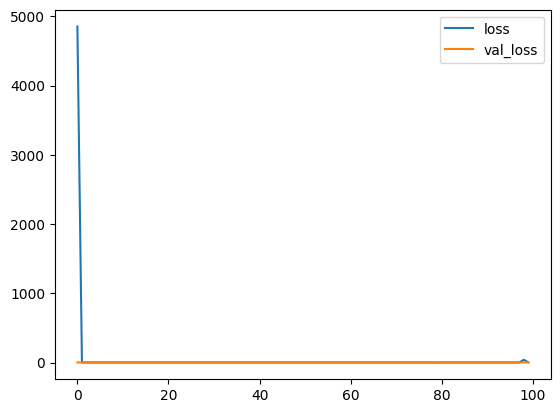

In [10]:
optimizer = Adam(learning_rate=0.0001)

model1 = Sequential()
""" CNN 1D Input data - https://wikidocs.net/192595
batch_size: 한 번에 처리할 데이터 샘플의 개수
sequence_length(time_steps): 입력 시퀀스(time)의 길이
input_dim(feature): 입력 시퀀스의 특성수 (예: 단어 임베딩 벡터의 차원)
"""

model1.add(LSTM(48, activation="relu", input_shape=(train_x_tensor.shape[1],train_x_tensor.shape[2])))
model1.add(Dropout(rate=0.2))
model1.add(Dense(units=48))
model1.compile(loss="mse", optimizer=optimizer)

trained = model1.fit(train_x1, train_y, validation_split=0.1, batch_size=20, epochs=100)
pd.DataFrame.from_dict(trained.history).plot()

Epoch 1/100
1251/1251 [==============================] - 3s 2ms/step - loss: 26938.1719 - val_loss: 188.1196
Epoch 2/100
1251/1251 [==============================] - 2s 2ms/step - loss: 2546.8657 - val_loss: 68.2105
Epoch 3/100
1251/1251 [==============================] - 2s 2ms/step - loss: 981.3452 - val_loss: 15.3887
Epoch 4/100
1251/1251 [==============================] - 2s 2ms/step - loss: 348.1161 - val_loss: 11.1840
Epoch 5/100
1251/1251 [==============================] - 2s 1ms/step - loss: 143.3184 - val_loss: 3.7048
Epoch 6/100
1251/1251 [==============================] - 2s 2ms/step - loss: 42.8567 - val_loss: 4.2222
Epoch 7/100
1251/1251 [==============================] - 2s 2ms/step - loss: 9.0869 - val_loss: 2.2265
Epoch 8/100
1251/1251 [==============================] - 2s 2ms/step - loss: 2.3143 - val_loss: 2.8078
Epoch 9/100
1251/1251 [==============================] - 2s 2ms/step - loss: 1.2154 - val_loss: 2.6998
Epoch 10/100
1251/1251 [==============================

<Axes: >

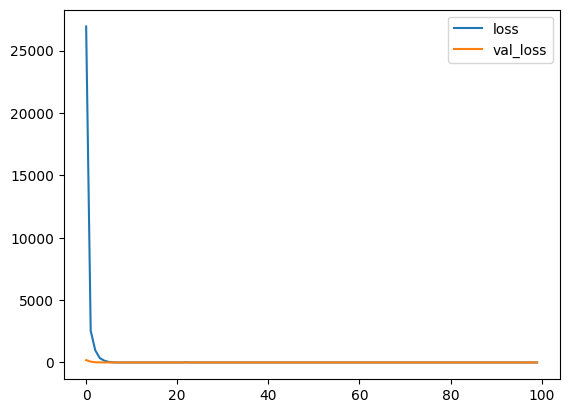

In [11]:
model2 = Sequential()
model2.add(LSTM(48, activation="relu", input_shape=(train_x_tensor2.shape[1],train_x_tensor2.shape[2])))
model2.add(Dropout(rate=0.2))
model2.add(Dense(units=48))
model2.compile(loss="mse", optimizer=optimizer)

trained2 = model1.fit(train_x2, train_y, validation_split=0.1, batch_size=30, epochs=100)
pd.DataFrame.from_dict(trained2.history).plot()

In [31]:
result1 = model1.predict(test_x1)
result2 = model1.predict(test_x2)

559/559 [==============================] - 0s 564us/step


AttributeError: 'numpy.ndarray' object has no attribute 'index'

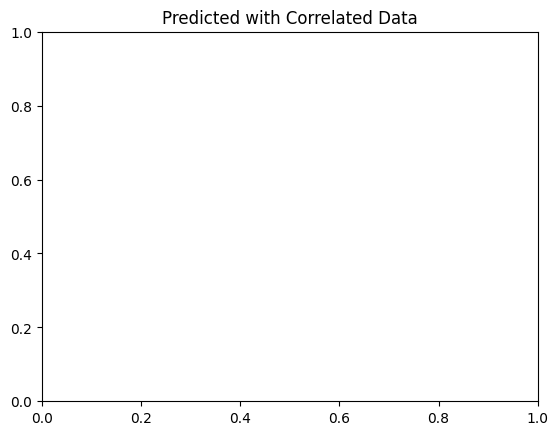

In [46]:
import matplotlib.pyplot as plt

plt.title("Predicted with Correlated Data")
plt.plot( test_y.index, result1, c="b", label="predicted")
plt.plot( test_y.index, test_y.values,c="g", alpha=.5, label="raw")
plt.legend(loc="best")

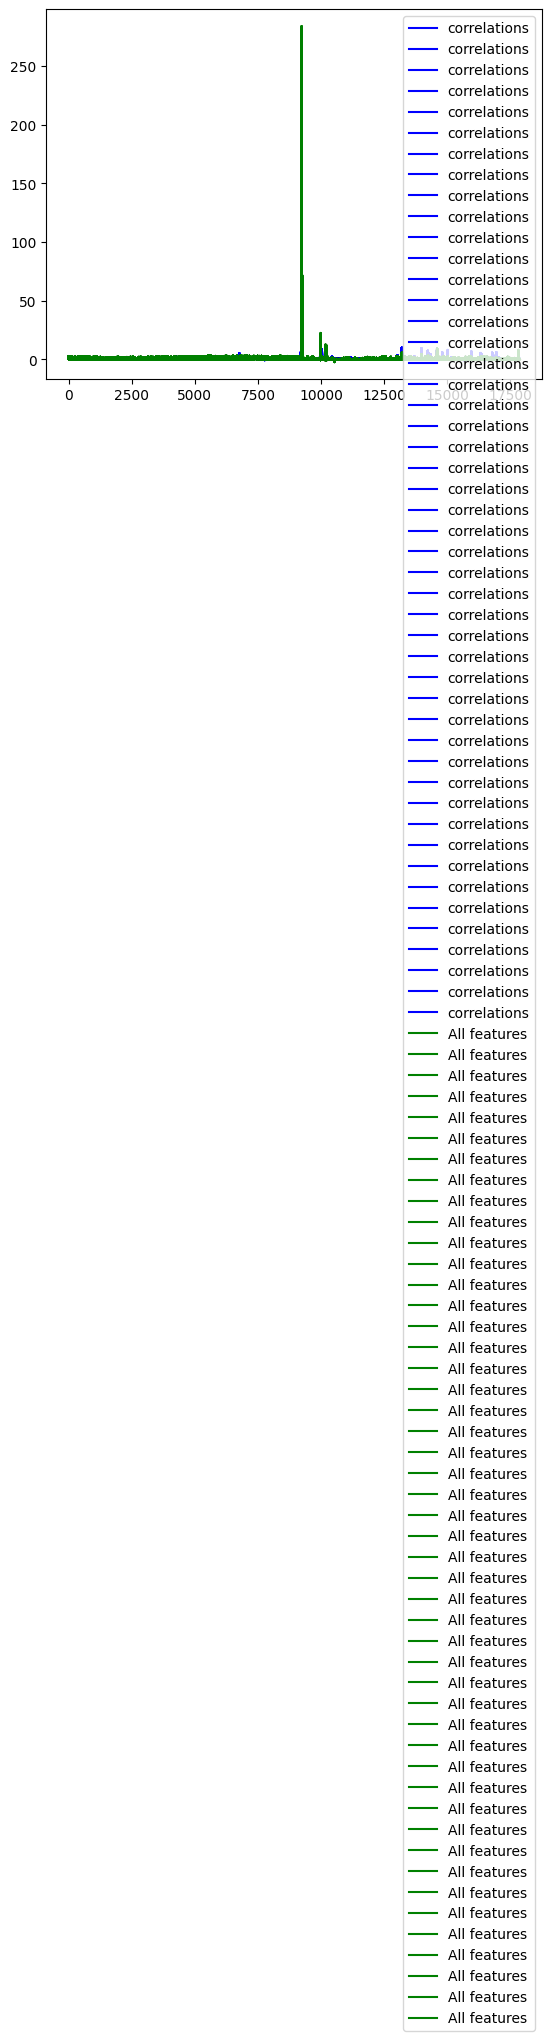

In [33]:


plt.plot(result1, c="b", label="correlations")
plt.plot(result2, c="g", label="All features")
plt.legend(loc="best")


In [21]:
from sklearn.metrics import mean_squared_error

mse1 = mean_squared_error(test_df[["solar_radiation"]], abs(result1))
mse2 = mean_squared_error(test_df[["solar_radiation"]], abs(result2))


ValueError: y_true and y_pred have different number of output (1!=48)